In [1]:
# EEG analysis tools
import mne
import ssvepy
from autoreject import Ransac
# scicomp tools
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
# notebook tools
from tqdm import tqdm_notebook
from ipywidgets import interact

mne.utils.set_log_level('WARNING')

/Library/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
stimfreqs = np.array([28.8, 36.0])

triggers = [22, 21, 11, 12]

fmin, fmax = 2.0, 150


In [4]:
datafolder = '/Users/jan/Documents/eeg-data/big-protocol/'
files = [file for file in glob(datafolder + '*MSSVEP*.bdf')]

group = np.array([1 if 'ASC' in file else 0 for file in files])

print(f'{len(files)}')
print(f'{group.sum()} patients.')
print(f'{group.size - group.sum()} controls.')

46
14 patients.
32 controls.


In [5]:
# create a raw class for each participant
# NB mne doesn't load the data straight away, this is just info structures
raws = [mne.io.read_raw_edf(file, eog=['EXG' + str(i) for i in range(9)],
                            montage=mne.channels.read_montage('biosemi64'),
                            verbose='WARNING')
       for file in files]
# For now, we'll just work with the EEG channels:
picks = [mne.pick_types(raw.info, eeg=True) for raw in raws]

# Add the 3D Montage
mtg = mne.channels.read_montage('biosemi64')
for raw in raws:
    raw.set_montage(mtg)


In [6]:
# read the events
events = [mne.find_events(raw, stim_channel='STI 014', verbose='WARNING')
          for raw in tqdm_notebook(raws)]
# choose the events that are actual start triggers (255=end of trial)
eventids = [event[:, 2][event[:, 2] < 255].tolist()
            for event in events]
# There are some cases in which the trigger was not at 0,
# so we need to turn those into the missing numbers
for i, ts in enumerate(eventids):
    for j, t in enumerate(ts):
        if t > 22:
            for replacement in triggers:
                # if there are less than 4 of the trigger, it's the culprit:
                if ts.count(replacement) < 4:
                    eventids[i][j] = replacement
                    events[i][j, 2] = replacement


In [9]:
# Create two separate sets of epochs, one for 11, 12, one for 21, 22
# the outer list has the subjects, the inner list the two epoch types
epochs = [
    [mne.Epochs(raw, events=event, event_id=eventids,
                tmin=0, tmax=8, picks=pick)
     for eventids in [[21, 22], [11, 12]]]
    for raw, event, pick in tqdm_notebook(zip(raws, events, picks))
]

In [10]:
# Re-sample the data to make it easier to handle
for both_epochs in tqdm_notebook(epochs, desc='Subjects'):
    for epoch in both_epochs:
        # NB both of these operate in-place
        epoch.load_data()
        epoch.resample(256)

In [11]:
# Notch-filter the data for the mains supply
# for both_epochs in tqdm_notebook(epochs, desc='Subjects'):
#     for epoch in both_epochs:
#         epoch.notch_filter(np.arange(50, 151, 50))

In [12]:
# Re-reference the data
for both_epochs in tqdm_notebook(epochs, desc='Subjects'):
    for epoch in both_epochs:
        # both of these operate in place
        epoch.set_eeg_reference()
        epoch.apply_proj()

In [30]:
# Create the SSVEP analysis structures
ssveps = [
    [ssvepy.Ssvep(epoch, [stimfreq],
                  fmin=fmin, fmax=110,
                  compute_harmonics = range(2, 6),
                  compute_subharmonics = range(2, 6))
     for epoch, stimfreq in zip(both_epochs, stimfreqs)]
    for both_epochs in tqdm_notebook(epochs, desc='Subjects')
]


In [46]:
ssveps[35][0].plot_snr(show=False)
plt.savefig('example-snr.pdf', transparent=True)

In [43]:
def plot_spec(subjectno, stimfreq, spectype='snr'):
    if spectype=='snr':
        ssveps[subjectno][stimfreq].plot_snr()
    elif spectype=='psd':
        ssveps[subjectno][stimfreq].plot_psd()

interact(plot_spec,
         subjectno=(0, len(files)-1, 1),
         stimfreq=(0, 1, 1),
         spectype=['snr', 'psd']);



---

## Stats Analysis

In [16]:
import pandas as pd
import statsmodels
import statsmodels.formula.api
from statsmodels.stats.anova import anova_lm
import scipy

In [17]:
# Compare SNR of the two groups at stimulation at the occipital electrodes
electrodes = [ssveps[0][0].ch_names.index(elec)
              for elec in['Oz', 'O1', 'O2', 'POz', 'Iz']]
stimsnrs = np.stack([
    np.stack([ssvep.stimulation.snr[:, electrodes].mean() * 10**12
              for ssvep in both_ssveps])
    for both_ssveps in ssveps
])

# stimsnrs = pd.DataFrame(data=stimsnrs, columns=[str(f) for f in stimfreqs])
# stimsnrs['group'] = group
# stimsnrs['subject'] = [file[-15:-11] for file in files]

# # Melt into tidy format
# stimsnrs = pd.melt(stimsnrs, id_vars=['subject', 'group'],
#                    value_name='snr', var_name='stimulationfrequency',
#                    value_vars=[str(f) for f in stimfreqs])

# model = statsmodels.formula.api.ols(
#     data=stimsnrs, formula='snr ~ C(group) + C(stimulationfrequency) + C(group):C(stimulationfrequency)'
# ).fit()
# aov_table = anova_lm(model, typ=2)

scipy.stats.ttest_ind(stimsnrs[group==0, 0], stimsnrs[group==1, 0])
print(scipy.stats.ttest_ind(stimsnrs[group==0, 1], stimsnrs[group==1, 1]))

Ttest_indResult(statistic=-0.33003104910748809, pvalue=0.74294272164657749)


In [31]:
# Compare the non-linear SNRs
harmonicsnrs = np.stack([
    np.stack([ssvep.harmonic.snr[:, electrodes].mean(axis=(0, 1)) * 10**12
              for ssvep in both_ssveps],
             axis=1)
    for both_ssveps in ssveps
], axis=2)

harmonicamps = np.stack([
    np.stack([ssvep.harmonic.power[:, electrodes].mean(axis=(0, 1)) * 10**12
              for ssvep in both_ssveps],
             axis=1)
    for both_ssveps in ssveps
], axis=2)

subharmonicamps = np.stack([
    np.stack([ssvep.subharmonic.power[:, electrodes].mean(axis=(0, 1)) * 10**12
              for ssvep in both_ssveps],
             axis=1)
    for both_ssveps in ssveps
], axis=2)

subharmonicsnrs = np.stack([
    np.stack([ssvep.subharmonic.snr[:, electrodes].mean(axis=(0, 1)) * 10**12
              for ssvep in both_ssveps],
             axis=1)
    for both_ssveps in ssveps
], axis=2)

In [27]:
ydata=harmonicamps[:, iorder, :]
ydata[0, :] > (ydata[0, :].mean() + 2*ydata[0, :].std())
ydata[1, :] > (ydata[1, :].mean() + 2*ydata[1, :].std())

/Library/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False], dtype=bool)

/Library/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/Library/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


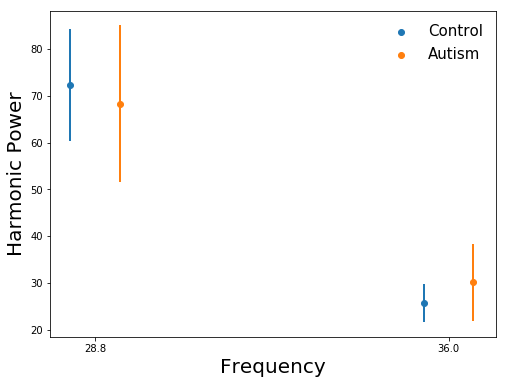

In [42]:
# Plot differenes

plt.figure(figsize=(8, 6))

for iorder in range(1):
#     plt.subplot(3, 2, 3+iorder)
    ydata=np.mean(harmonicamps[:, :, :], axis=1)
    # remove outliers
    ydata[0, ydata[0, :] > (np.nanmean(ydata[0, :]) + 3*np.nanstd(ydata[0, :]))] = np.nan
    ydata[1, ydata[1, :] > (np.nanmean(ydata[1, :]) + 3*np.nanstd(ydata[1, :]))] = np.nan
    labels=['Control', 'Autism']
    for igroup in range(2):
        plt.scatter(stimfreqs - 0.5 + igroup,
                    [np.nanmean(ydata[0, group==igroup]),
                     np.nanmean(ydata[1, group==igroup])],
                    label=labels[igroup])
        plt.errorbar(stimfreqs - 0.5 + igroup,
                     [np.nanmean(ydata[0, group==igroup]),
                      np.nanmean(ydata[1, group==igroup])],
                     yerr=[scipy.stats.sem(ydata[0, group==igroup], nan_policy='omit'),
                           scipy.stats.sem(ydata[1, group==igroup], nan_policy='omit')],
                     linewidth=0, elinewidth=2)
        plt.xticks(stimfreqs)
        plt.xlabel('Frequency', size=20)
        plt.ylabel('Harmonic Power', size=20)
        plt.legend(fontsize=15, framealpha=0.0)
        plt.set_cmap('viridis')


plt.savefig('harmonic-power.pdf', transparent=True)
plt.show()

In [20]:
harmonicamps[:, iorder, :]

array([[  5.66203319e+01,   7.28324250e+01,   1.84995993e+01,
          8.35563457e+01,   5.16814139e+01,   5.53647642e+01,
          1.08938546e+01,   7.55375631e+01,   8.34351227e+01,
          5.50339664e+01,   4.85286357e+01,   1.39307351e+01,
          1.43114149e+01,   3.76098042e+01,   1.82482577e+01,
          6.17907691e+01,   4.65532972e+01,   1.29416707e+04,
          2.99963728e+01,   1.21639061e+01,   6.66426455e+00,
          2.38530036e+01,   1.65773535e+01,   1.07959263e+01,
          4.58723883e+01,   7.67826679e+01,   2.50946984e+01,
          9.56519954e+01,   8.00835879e+01,   4.68504471e+01,
          5.30902622e+01,   5.26672380e+01,   1.40791701e+02,
          5.18557096e+01,   1.36815469e+02,   6.91611778e+01,
          6.44605744e+01,   1.35964158e+02,   7.00790447e+02,
          8.19002163e+01,   1.16367954e+01,   1.85078558e+01,
          7.38672828e+01,   2.10213260e+01,   2.18522145e+01,
          4.84480426e+01],
       [  3.40498873e+01,   6.19726882e+01,